In [16]:
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve,confusion_matrix,accuracy_score, auc

from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler

from pylab import rcParams
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from tensorflow import keras
from keras import Sequential
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.layers import Conv1D, MaxPool1D
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc

import imblearn
from imblearn.over_sampling import SMOTE

In [17]:
# Read the dataset
df = pd.read_csv('F:creditcard.csv')
#check on the size of the dataframe

df=shuffle(df)
df.shape

(284807, 31)

In [18]:
# We separate the feature vector from the classification result
X = df.drop('Class',axis=1).values
y = df['Class'].values

In [19]:
# Feature scaling
X -= X.min(axis=0)
X /= X.max(axis=0)

In [20]:
#Separation of data into training & test sets
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.3)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
X_train.shape

(199364, 30)

In [21]:
print("Before OverSampling, counts of label '1': {}".format(sum(y==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y==0)))

sm = SMOTE(random_state=2)
X_res_train, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_res_train.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 492
Before OverSampling, counts of label '0': 284315 



F:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After OverSampling, the shape of train_X: (398014, 30)
After OverSampling, the shape of train_y: (398014,) 

After OverSampling, counts of label '1': 199007
After OverSampling, counts of label '0': 199007


In [22]:
nb_epoch = 100
#batch_size = 256
input_dim = X_res_train.shape[1] #num of columns, 30
encoding_dim_1 = 27
encoding_dim_2 = 24
encoding_dim_3 = 21
hidden_dim = 15
learning_rate = 1e-7
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim_1, activation="elu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(encoding_dim_2, activation = "elu")(encoder)
encoder = Dense(encoding_dim_3, activation = "elu")(encoder)

encoder = Dense(hidden_dim, activation="elu")(encoder)

decoder = Dense(encoding_dim_3, activation = "elu")(encoder)
decoder = Dense(encoding_dim_2, activation = "elu")(decoder)
decoder = Dense(encoding_dim_1, activation = "elu")(decoder)
decoder = Dense(input_dim, activation="elu")(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [23]:
# Create the autoencoder model
autoencoder = Model(input_layer, decoder)
#Compile the autoencoder model
autoencoder.compile(optimizer='adam',
loss='mean_squared_error')
#Fit to train set and save to hist_auto for plotting purposes
hist_auto = autoencoder.fit(X_res_train, X_res_train,
epochs=50,
#batch_size=256,
shuffle=True,
validation_data=(X_test, X_test))

Train on 398014 samples, validate on 85443 samples
Epoch 1/50
398014/398014 [==============================] - 55s 139us/step - loss: 0.0011 - val_loss: 2.8536e-04
Epoch 2/50
398014/398014 [==============================] - 54s 134us/step - loss: 1.6065e-04 - val_loss: 1.7618e-04
Epoch 3/50
398014/398014 [==============================] - 57s 144us/step - loss: 1.3260e-04 - val_loss: 1.4285e-04
Epoch 4/50
398014/398014 [==============================] - 55s 139us/step - loss: 1.1227e-04 - val_loss: 1.2057e-04
Epoch 5/50
398014/398014 [==============================] - 56s 141us/step - loss: 1.0034e-04 - val_loss: 1.0779e-04
Epoch 6/50
398014/398014 [==============================] - 56s 141us/step - loss: 9.3259e-05 - val_loss: 1.0052e-04
Epoch 7/50
398014/398014 [==============================] - 54s 136us/step - loss: 8.6855e-05 - val_loss: 9.5131e-05
Epoch 8/50
398014/398014 [==============================] - 57s 144us/step - loss: 8.1809e-05 - val_loss: 9.3171e-05
Epoch 9/50
398014

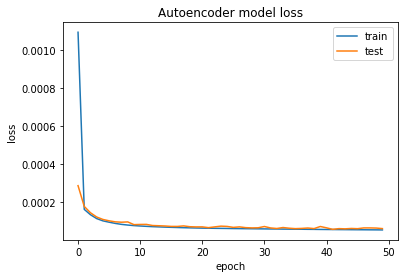

In [24]:
# Summarize history for loss
plt.figure()
plt.plot(hist_auto.history['loss'])
plt.plot(hist_auto.history['val_loss'])
plt.title('Autoencoder model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [25]:
# Create a separate model (encoder) in order to make encodings (first part of the autoencoder model)
encoder_model = Model(input_layer, encoder)
# Create a placeholder for an encoded input
encoded_input = Input(shape=(hidden_dim,))

In [26]:
#Encode data set from above using the encoder
encoded_train_x = encoder_model.predict(X_res_train)
encoded_test_x = encoder_model.predict(X_test)
#Reshape data for the CNN model
encoded_train_x = encoded_train_x.reshape(encoded_train_x.shape[0],encoded_train_x.shape[1], 1)
encoded_test_x = encoded_test_x.reshape(encoded_test_x.shape[0], encoded_test_x.shape[1], 1)
encoded_train_x.shape

(398014, 15, 1)

In [27]:
#--------------------------------Build new model using encoded data--------------------------
epochs = 100
model = Sequential()
model.add(Conv1D(32, 2, activation='relu', input_shape = encoded_train_x[1].shape))
model.add(BatchNormalization())
model.add(MaxPool1D(2))
model.add(Dropout(0.2))

model.add(Conv1D(64, 2, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool1D(2))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(lr=0.0001), loss = 'binary_crossentropy',metrics=['accuracy'])
history = model.fit(encoded_train_x, y_train_res, epochs=epochs,validation_data=(encoded_test_x, y_test), verbose=1)

Train on 398014 samples, validate on 85443 samples
Epoch 1/100
398014/398014 [==============================] - 213s 535us/step - loss: 0.2690 - accuracy: 0.8883 - val_loss: 0.1398 - val_accuracy: 0.9775
Epoch 2/100
398014/398014 [==============================] - 203s 511us/step - loss: 0.1663 - accuracy: 0.9319 - val_loss: 0.1087 - val_accuracy: 0.9734
Epoch 3/100
398014/398014 [==============================] - 185s 466us/step - loss: 0.1402 - accuracy: 0.9428 - val_loss: 0.0934 - val_accuracy: 0.9743
Epoch 4/100
398014/398014 [==============================] - 183s 459us/step - loss: 0.1273 - accuracy: 0.9482 - val_loss: 0.0813 - val_accuracy: 0.9756
Epoch 5/100
398014/398014 [==============================] - 187s 469us/step - loss: 0.1190 - accuracy: 0.9519 - val_loss: 0.0732 - val_accuracy: 0.9769
Epoch 6/100
398014/398014 [==============================] - 214s 538us/step - loss: 0.1126 - accuracy: 0.9550 - val_loss: 0.0717 - val_accuracy: 0.9776
Epoch 7/100
398014/398014 [====

Epoch 54/100
398014/398014 [==============================] - 162s 406us/step - loss: 0.0738 - accuracy: 0.9726 - val_loss: 0.0387 - val_accuracy: 0.9873
Epoch 55/100
398014/398014 [==============================] - 161s 405us/step - loss: 0.0750 - accuracy: 0.9720 - val_loss: 0.0392 - val_accuracy: 0.9874
Epoch 56/100
398014/398014 [==============================] - 162s 406us/step - loss: 0.0742 - accuracy: 0.9725 - val_loss: 0.0413 - val_accuracy: 0.9861
Epoch 57/100
398014/398014 [==============================] - 162s 406us/step - loss: 0.0745 - accuracy: 0.9723 - val_loss: 0.0444 - val_accuracy: 0.9849
Epoch 58/100
398014/398014 [==============================] - 162s 407us/step - loss: 0.0740 - accuracy: 0.9726 - val_loss: 0.0403 - val_accuracy: 0.9867
Epoch 59/100
398014/398014 [==============================] - 162s 406us/step - loss: 0.0737 - accuracy: 0.9726 - val_loss: 0.0416 - val_accuracy: 0.9859
Epoch 60/100
398014/398014 [==============================] - 162s 406us/ste

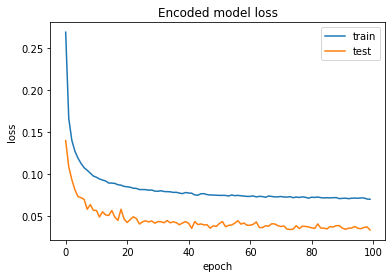

In [28]:
# Summarize history for loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Encoded model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Overall accuracy of Convolutional Neural Network model: 0.9954355535269127


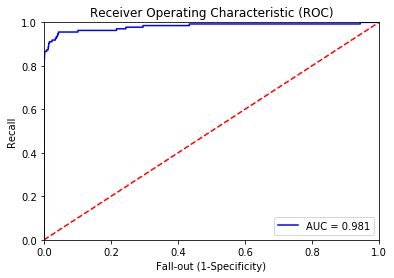

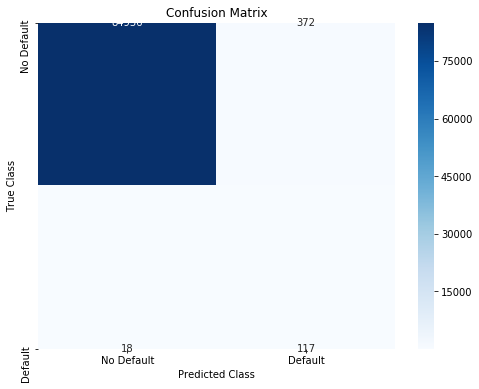

In [29]:
#---------------------------------Predictions and visuallizations-----------------------#Predict on test set
predictions_CNN_prob = model.predict(encoded_test_x)
predictions_CNN_prob = predictions_CNN_prob[:,0]
predictions_CNN_01 = np.where(predictions_CNN_prob > 0.7, 1, 0) #Turn probability to 0-1 binary output
#Print accuracy
acc_CNN = accuracy_score(y_test, predictions_CNN_01)
print('Overall accuracy of Convolutional Neural Network model:', acc_CNN)
#Print Area Under Curve
false_positive_rate, recall, thresholds = roc_curve(y_test,predictions_CNN_prob)
roc_auc = auc(false_positive_rate, recall)
plt.figure()
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
#Print Confusion Matrix
cm = confusion_matrix(y_test, predictions_CNN_01)
labels = ['No Default', 'Default']
plt.figure(figsize=(8,6))
sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d',cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()